In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import warnings
with warnings.catch_warnings():
        warnings.simplefilter("ignore")

In [2]:
def calc_theta(x, ineq_constraints):
    log = 0
    d = 0
    hess1 = 0
    hess2 = 0
    h, dh, dh_2 = ineq_constraints()
    
    for h_i, dh_i, dh2_i in zip(h, dh, dh_2):
        h_i_x = h_i(x)
        log += np.log((-1) * h_i_x)
        d += (dh_i / ((-1) * h_i_x))
        hess1 += (np.matmul(dh_i, dh_i.T) / (h_i_x * h_i_x))
        hess2 += (dh2_i / ((-1) * h_i_x))

    return (-1) * log, d, hess1+hess2


def log_barrier(x, f, ineq_constraints, t):
    theta, d_theta, h_theta = calc_theta(x, ineq_constraints)
    f_x, grad_x, hess_x = f(x)

    log_barr_f = (t * f_x) + theta
    log_barr_g = (t * grad_x) + d_theta
    log_barr_h = (t * hess_x) + h_theta

    return log_barr_f, log_barr_g, log_barr_h


def line_search(x, f, step, ineq_constraints, t, init_step_len, slope_ratio, back_track_factor):
    alpha = init_step_len
    log_barr_f, log_barr_g_xk, _ = log_barrier(x, f, ineq_constraints, t)
    log_barr_f_next, _, _ = log_barrier((x + (alpha * step)), f, ineq_constraints, t)

    while np.isnan(log_barr_f_next) or (log_barr_f_next - log_barr_f) > (slope_ratio * alpha * np.matmul(log_barr_g_xk.T, step)):
        alpha *= back_track_factor
        log_barr_f_next, _, _ = log_barrier((x + (alpha * step)), f, ineq_constraints, t)

    return alpha


def newton(x_p,hessian_p):
    I = np.identity(hessian_p.shape[0])
    B = np.linalg.solve(hessian_p, I)
    return (-1) * B.dot(x_p)


def newton_method(x0, f, ineq_constraints, t, n_equ_const, A, epsilon, init_step_len, slope_ratio,back_track_factor, count, max_iter=100):
    outer_obj = []
    obj = []
    success = False
    xk = x0
    xs = [xk]
    
    for k in range(max_iter):
        log_barr_f_xk, log_barr_g_xk, log_barr_h_xk = log_barrier(xk, f, ineq_constraints, t)

        if n_equ_const > 0:
            M1 = np.concatenate((log_barr_h_xk, A.T), axis=1)
            M2 = np.concatenate((A, np.zeros((n_equ_const, n_equ_const))), axis=1)
            M = np.concatenate((M1, M2), axis=0)
            v = np.concatenate(((-1) * log_barr_g_xk, np.zeros((n_equ_const, 1))))
            X = np.linalg.solve(M, v)
            step = X[:log_barr_h_xk.shape[0]]
        else:
            step = newton(log_barr_g_xk, log_barr_h_xk)

        lambda_x = np.sqrt(np.matmul(np.matmul(step.T, log_barr_h_xk), step))
        if (0.5 * lambda_x * lambda_x) < epsilon:
            success = True
            return xk, success, count,obj,outer_obj,xs

        step_len = line_search(xk, f, step, ineq_constraints, t, init_step_len, slope_ratio,back_track_factor)
        xk1 = xk + (step_len * step)
        f_xk, _, _ = f(xk)
        f_xk1, _, _ = f(xk1)        
        print("Iteration number = {}\n \
               Location = {} \n \
               Objective value = {}\n \
               Step length = {} \n \
               objective Change = {}"
               .format(count, xk1, f_xk1,np.linalg.norm(xk - xk1),np.linalg.norm(f_xk1 - f_xk)))
        
        obj.append(f_xk)
        outer_obj.append(np.linalg.norm(f_xk1 - f_xk))
        xs.append(xk1)
        
        xk = xk1
        count += 1

    return xk, success, count,obj,outer_obj,xs


def interior(f, ineq_constraints, eq_constraints_mat, eq_constraints_rhs, x0, init_step_len,slope_ratio, back_track_factor, t=1, mu=10, max_iter_outer=100, max_iter_inner=100,epsilon = 1e-4):
    outer_obj_values = []
    obj_values = []
    x_s = []
    A = eq_constraints_mat
    b = eq_constraints_rhs
    n_equ_const = A.shape[0] 
    h_list, dh_list, hess_list = ineq_constraints()
    n_ineq_const = len(h_list)
    count = 0
    x_prev = x0
    success_outer = False
    
    for i in range(max_iter_outer):
        x_next, success,count,obj,outer_obj,xs = newton_method(x_prev, f, ineq_constraints, t, n_equ_const, A,epsilon, init_step_len, slope_ratio,back_track_factor, count, max_iter_inner)
        if not success:
            return x_next,obj_values,outer_obj_values,x_s

        obj_values += obj
        outer_obj_values += outer_obj
        x_s+=xs

        if n_ineq_const/t < epsilon:
            success_outer = True
            return x_next,obj_values,outer_obj_values,x_s

        t = t*mu
        x_prev = x_next

    return x_next,obj_values,outer_obj_values,x_s

In [3]:
## Examples
# quadratic problem
def quadratic_problem(x):
    f_x = (x[0][0] * x[0][0]) + (x[1][0] * x[1][0]) + ((x[2][0]+1) * (x[2][0]+1))
    grad_x = np.array([[2 * x[0][0]], [2 * x[1][0]], [2 * (x[2][0]+1)]])
    hess_x = np.array([[2, 0, 0],
                       [0, 2, 0],
                       [0, 0, 2]])
    return f_x, grad_x, hess_x


def quadratic_problem_ineq_constraints():
    h = [lambda x: -x[0][0], lambda x: -x[1][0], lambda x: -x[2][0]]
    dh = [np.array([[-1], [0], [0]]), np.array([[0], [-1], [0]]), np.array([[0], [0], [-1]])]
    dh_2 = [np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))]
    return h, dh, dh_2


# linear problem
def linear_problem(x):
    f_x = (-1)*(x[0][0] + x[1][0])
    grad_x = np.array([[-1], [-1]])
    hess_x = np.array([[0, 0], [0, 0]])
    return f_x, grad_x, hess_x


def lp_ineq_constraints():
    h = [lambda x: 1-x[0][0]-x[1][0], lambda x: x[1][0]-1, lambda x: x[0][0]-2, lambda x: -x[1][0]]
    dh = [np.array([[-1], [-1]]), np.array([[0], [1]]), np.array([[1], [0]]), np.array([[0], [-1]])]
    dh_2 = [np.zeros((2, 2)), np.zeros((2, 2)), np.zeros((2, 2)), np.zeros((2, 2))]
    return h, dh, dh_2

In [4]:
## Plots
def plot_iterations(title, obj1, obj2, label1, label2):
    fig, ax = plt.subplots()
    ax.plot(range(len(obj1)), obj1, label=label1)
    ax.plot(range(len(obj2)), obj2, label=label2)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Objective function value")
    plt.show()

    
def plot_feasible_set_3d(path):
    fig = plt.figure()
    ax = Axes3D(fig)
    x = [1, 0, 0]
    y = [0, 1, 0]
    z = [0, 0, 1]
    
    verts = [list(zip(x, y, z))]
    poly_3d_collection = Poly3DCollection(verts, alpha=0.5, edgecolors="k")
    ax.add_collection3d(poly_3d_collection)
    
    x,y,z=[],[],[]
    for i in range(len(path)):
        x.append(path[i][0][0])
        y.append(path[i][1][0])
        z.append(path[i][2][0])
        
    ax.plot(x,y,z,label="The algorithm's path",marker=".")
    plt.show()
      
    
def plot_linear_feasible_region(label,path):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    d = np.linspace(-1, 4, 2000)
    x, y = np.meshgrid(d, d)
    plt.imshow(
               ((y >= -x + 1) & (y <= 1) & (x <= 2) & (y >= 0)).astype(int),
               extent=(x.min(), x.max(), y.min(), y.max()),
               origin="lower",
               cmap="Greys",
               alpha=0.3,
              )
    
    x_path,y_path=[],[]
    for i in range(len(path)):
        x_path.append(path[i][0][0])
        y_path.append(path[i][1][0])
    
    x = np.linspace(0, 4, 2000)
    y1 = -x + 1
    y2 = np.ones(x.size)
    y3 = np.zeros(x.size)
    
    plt.plot(x, y1, label=r'$y\leq1$')
    plt.plot(x, y2, label=r'$y\geq0$')
    plt.plot(x, y3, label=r'$y\geq -x + 1$')
    plt.plot(np.ones(x.size) * 2, x ,label=r'$x\leq2$')
    plt.plot(x_path,y_path,label="The algorithm's path",marker=".")
    plt.xlim(0, 3)
    plt.ylim(0, 2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

Iteration number = 0
                Location = [[0.20345446]
 [0.39823538]
 [0.39831015]] 
                Objective value = 2.1552564252828783
                Step length = 0.37552211115896317 
                objective Change = 0.7847435747171212
Iteration number = 1
                Location = [[0.32862733]
 [0.45611439]
 [0.21525828]] 
                Objective value = 1.7928889424531351
                Step length = 0.22918598458067102 
                objective Change = 0.3623674828297432
Iteration number = 2
                Location = [[0.38279947]
 [0.38331248]
 [0.23388805]] 
                Objective value = 1.8159436117054648
                Step length = 0.09263804555333605 
                objective Change = 0.023054669252329685
Iteration number = 3
                Location = [[0.41254137]
 [0.412972  ]
 [0.17448663]] 
                Objective value = 1.720155096586078
                Step length = 0.07275160975091982 
                objective Change = 0.0957885151193869

<ipython-input-2-56f93e588715>:10: RuntimeWarning: invalid value encountered in log
  log += np.log((-1) * h_i_x)


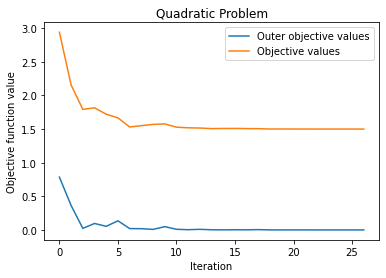

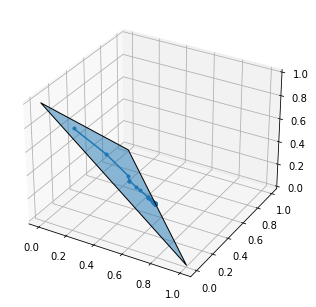

In [5]:
def test_quadratic_problem():
    start_point = np.array([[0.1], [0.2], [0.7]])
    init_step_len = 1.0
    slope_ratio = 1e-4
    back_track_factor = 0.2
    A = np.array([[1, 1, 1]])
    b = [[1]]
    X,obj_values,outer_obj_values,x_s = interior(quadratic_problem,quadratic_problem_ineq_constraints,A,b,start_point,init_step_len,slope_ratio,back_track_factor)
    
    plot_iterations("Quadratic Problem",outer_obj_values,obj_values,"Outer objective values","Objective values")
    plot_feasible_set_3d(x_s)
test_quadratic_problem()

Iteration number = 0
                Location = [[0.86411609]
 [0.6466029 ]] 
                Objective value = -1.5107189973614776
                Step length = 0.37851220644225436 
                objective Change = 0.26071899736147763
Iteration number = 1
                Location = [[1.31892666]
 [0.64176976]] 
                Objective value = -1.9606964242166982
                Step length = 0.45483624779125936 
                objective Change = 0.4499774268552206
Iteration number = 2
                Location = [[1.47687191]
 [0.69807483]] 
                Objective value = -2.1749467465817847
                Step length = 0.16768113642704857 
                objective Change = 0.21425032236508645
Iteration number = 3
                Location = [[1.46328417]
 [0.69672009]] 
                Objective value = -2.1600042613945045
                Step length = 0.013655110335581797 
                objective Change = 0.014942485187280141
Iteration number = 4
                Location =

<ipython-input-2-56f93e588715>:10: RuntimeWarning: invalid value encountered in log
  log += np.log((-1) * h_i_x)


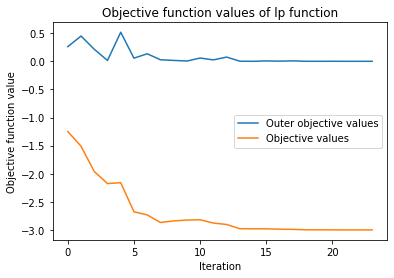

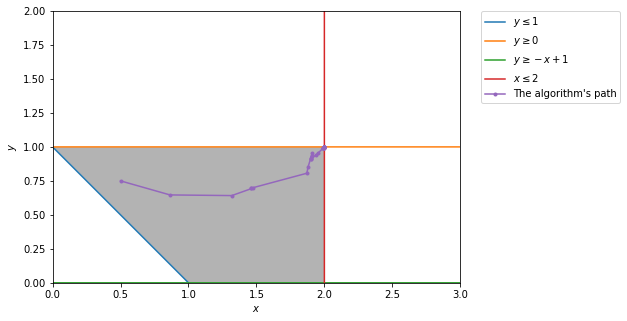

In [6]:
def test_linear_problem():
    start_point = np.array([[0.5], [0.75]])
    init_step_len = 1.0
    slope_ratio = 1e-4
    back_track_factor = 0.2
    A = np.zeros((0, 0))
    b = np.zeros((0))
    X,obj_values,outer_obj_values,x_s = interior(linear_problem,lp_ineq_constraints,A,b,start_point,init_step_len,slope_ratio,back_track_factor)
    
    plot_iterations("Objective function values of lp function",outer_obj_values,obj_values,"Outer objective values","Objective values")
    plot_linear_feasible_region("linear minimization problem - feasible region",x_s)
test_linear_problem()